## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

##### the proportion of users converted is 0.11965919355605512 

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').index)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.duplicated().value_counts()

False    290584
True          1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
duplicat = df2[df2.user_id.duplicated()]
duplicat

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# dropping duplicate values 
df2.drop(labels=2893,inplace=True)

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

##### the probability of an individual converting regardless of the page they receive is  0.11959708724499628 

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query(' group == "control" ').converted.mean()

0.1203863045004612

#####  Given that an individual was in the control group,  the probability they converted is  0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query(' group == "treatment" ').converted.mean()

0.11880806551510564

##### Given that an individual was in the treatment group, the probability they converted is 0.11880806551510564


d. What is the probability that an individual received the new page?

In [18]:
len(df2[df2['landing_page']== 'new_page'])/len(df2)

0.5000619442226688

##### The  probability that an individual received the new page 0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

###### It might seem that  the probability of control group is slitly greater than treatment group but no it is not sufficient evidence to conclude that the new treatment page leads to more conversions as half of users received the new page and the other half received the old page so we need A/B test 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


1. null hypothesis    **$p_{old}$** >= **$p_{new}$**
2. alternative hypothesis   **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# for the assumation below ,since under null hypothesis both p_new & p_old are equal
#, hence :
p_new = df2['converted'].mean()
p_new

0.11959708724499628

##### The conversion rate for p_new under the null 0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

##### The conversion rate for p_old under the null 0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query(' group == "treatment" ').user_id.count()
n_new

145310

#####  The number of individuals in the treatment group is 145310  

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query(' group == "control" ').user_id.count()
n_old

145274

##### The number of individuals in the control group is  145274 

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.1210446631339894

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11893387667442212

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0021107864595672765

#####  pnew - pold = 0.0021107864595672765 

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_pge_converted = np.random.binomial(1,p_new,n_new)
    old_pge_converted = np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_pge_converted.mean() - old_pge_converted.mean() )
    
p_diffs = np.array(p_diffs)
p_diffs

array([  2.52413990e-05,   9.61660921e-04,   1.17501327e-03, ...,
        -1.22028104e-03,  -3.87486456e-04,   8.99598174e-04])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

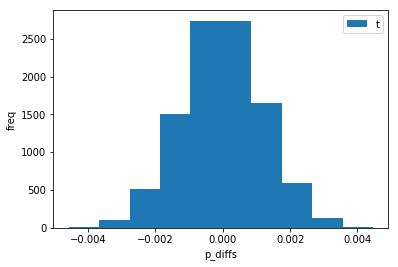

In [27]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('freq')
plt.legend('the propility of convertion from the old page to the new page');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
df2_control=df2.query(' group == "control" ')
df2_treatment=df2.query(' group == "treatment" ')
obs_diff=df2_treatment.converted.mean()-df2_control.converted.mean()
obs_diff

-0.0015782389853555567

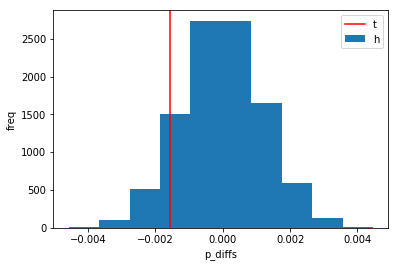

In [29]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.axvline(x=obs_diff,color='red',label='obs_diff')
plt.ylabel('freq')
plt.legend('the propility of convertion from the old page to the new page')
plt.show;

In [30]:
(p_diffs> obs_diff).mean()

0.90429999999999999

###### 90.42% is the proportion of the p_diffs are greater than the actual difference observed in ab_data.csv

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

######  90.42% is called p-value in scientific studies, it means that we cannot reject the null hypothesis , hence there is no suffienet evidence that there is a difference between the new and old pages 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:


convert_old =len(df2.query('landing_page == "old_page" and converted == 1 ') )
convert_new = len(df2.query('landing_page == "new_page" and converted == 1 '))
n_old = len(df2.query('landing_page == "old_page" ') )
n_new = len(df2.query('landing_page == "new_page" ') )


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
zstat,pval = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],value= None,alternative='smaller',prop_var=False)
zstat,pval

(1.3109241984234394, 0.90505831275902449)

##### zstat = 1.3109241984234394 & p-value =  0.90505831275902449

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

######  The z-score and p-value computed  mean for the conversion rates of the old and new pages that we cannot reject the null hypothesis,which is the converted rate for old page is same as or greater than the new pages as the p-value is greater than 0.05 significance level 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#####  Since each row is either a conversion or no conversion, the type of regression should  be performing in this case is logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept']=1
df2[['treatment','control']]=pd.get_dummies(df2['group'])
df2=df2.drop('control',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


In [34]:
df_new=df2.rename(columns={'treatment': 'ab_page'})
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page']])
res=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-12 19:57 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

######  p-value associated with ab_page is equal 0.1899 
###### p-value is differ from the value you found in Part II because we are testing different hypotheses
###### the null and  alternative hypotheses associated with your regression model is if the convertion rate are equal or not but in Part II if the difference in the converted  are  from old page to new page are less orequal zero .

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

###### Additional terms will always improve the model and make test suffienet whether the new term adds significant value to the model or not. As a matter of fact, adding new variables can actually make the model worse. Adding more and more variables makes it more and more likely that you will overfit your model to the training data.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
df_c=pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
df_new=df_c.set_index('user_id').join(df_new.set_index('user_id'),how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0


In [39]:
#Check for NaNfor the entire DataFrame after merging:
df_new.isnull().values.any()

False

In [40]:
df_new[['US','UK','CA']]=pd.get_dummies(df_new['country'])
df_new.drop(columns='CA',axis=1,inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','UK_ab_page','US_ab_page']])
res=lm.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-12 19:57 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0070    0.0097  -207.0454  0.0000  -2.0260  -1.9880
ab_page       0.0206    0.0137     1.5052  0.1323  -0.0062   0.0473
US           -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
UK            0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
UK_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
US_ab_page    0.0469    0.0538     0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

##### the p-value of ab_page is changed to 0.1323 and that is not statisticaly significant .

<a id='conclusions'></a>
## Conclution
At the end we conclude that we cannot reject the null hypothesis ,hence it is not recommended to launch the new page for production .

In [42]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])